In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import torchvision
import torchvision.models as models
from torch.autograd import Variable
import torch.utils.data as data
import torchvision.transforms as transforms
from torchvision.datasets import MNIST, EMNIST, CIFAR10,CIFAR100
from PIL import Image
import torch.optim as optim
import numpy as np
from sklearn.metrics import confusion_matrix
# from resnetcifar import ResNet18_cifar10, ResNet50_cifar10
import logging

logging.basicConfig()
logger = logging.getLogger()
logger.setLevel(logging.INFO)
from tensorboardX import SummaryWriter
writer = SummaryWriter("logs")

In [28]:
class SimpleCNN_header(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim=10):
        super(SimpleCNN_header, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)

        # for now, we hard coded this network
        # i.e. we fix the number of hidden layers i.e. 2 layers
        self.fc1 = nn.Linear(input_dim, hidden_dims[0])
        self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
        #self.fc3 = nn.Linear(hidden_dims[1], output_dim)

    def forward(self, x):

        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)

        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        # x = self.fc3(x)
        return x

In [29]:
class ModelFedCon(nn.Module):

    def __init__(self, base_model, out_dim, n_classes, net_configs=None):
        super(ModelFedCon, self).__init__()

        if base_model == "resnet50-cifar10" or base_model == "resnet50-cifar100" or base_model == "resnet50-smallkernel" or base_model == "resnet50":
            basemodel = ResNet50_cifar10()
            self.features = nn.Sequential(*list(basemodel.children())[:-1])
            num_ftrs = basemodel.fc.in_features
        elif base_model == "resnet18-cifar10" or base_model == "resnet18":
            basemodel = ResNet18_cifar10()
            self.features = nn.Sequential(*list(basemodel.children())[:-1])
            num_ftrs = basemodel.fc.in_features
        elif base_model == "mlp":
            self.features = MLP_header()
            num_ftrs = 512
        elif base_model == 'simple-cnn':
            self.features = SimpleCNN_header(input_dim=(16 * 5 * 5), hidden_dims=[120, 84], output_dim=n_classes)
            num_ftrs = 84
        elif base_model == 'simple-cnn-mnist':
            self.features = SimpleCNNMNIST_header(input_dim=(16 * 4 * 4), hidden_dims=[120, 84], output_dim=n_classes)
            num_ftrs = 84

        #summary(self.features.to('cuda:0'), (3,32,32))
        #print("features:", self.features)
        # projection MLP
        self.l1 = nn.Linear(num_ftrs, num_ftrs)
        self.l2 = nn.Linear(num_ftrs, out_dim)

        # last layer
        self.l3 = nn.Linear(out_dim, n_classes)

    def _get_basemodel(self, model_name):
        try:
            model = self.model_dict[model_name]
            #print("Feature extractor:", model_name)
            return model
        except:
            raise ("Invalid model name. Check the config file and pass one of: resnet18 or resnet50")

    def forward(self, x):
        h = self.features(x)
        #print("h before:", h)
        #print("h size:", h.size())
        h = h.squeeze()
        #print("h after:", h)
        x = self.l1(h)
        x = F.relu(x)
        x = self.l2(x)

        y = self.l3(x)
        return h, x, y

In [30]:
# net = ModelFedCon("simple-cnn",256,10)
# # net = SimpleCNNMNIST(input_dim=(16 * 4 * 4), hidden_dims=[120, 84], output_dim=10)
# net = nn.DataParallel(net)
# net = net.cpu()

In [31]:
def compute_accuracy(model, dataloader, get_confusion_matrix=False, device="cpu", multiloader=False):
    was_training = False
    if model.training:
        model.eval()
        was_training = True

    true_labels_list, pred_labels_list = np.array([]), np.array([])

    correct, total = 0, 0
    if device == 'cpu':
        criterion = nn.CrossEntropyLoss()
    elif device == 'cuda':
        criterion = nn.CrossEntropyLoss().cuda()
    loss_collector = []
    if multiloader:
        for loader in dataloader:
            with torch.no_grad():
                for batch_idx, (x, target) in enumerate(loader):
                    #print("x:",x)
                    #print("target:",target)
                    if device != 'cpu':
                        x, target = x.cuda(), target.to(dtype=torch.int64).cuda()
                    _, _, out = model(x)
                    if len(target)==1:
                        loss = criterion(out, target)
                    else:
                        loss = criterion(out, target)
                    _, pred_label = torch.max(out.data, 1)
                    loss_collector.append(loss.item())
                    total += x.data.size()[0]
                    correct += (pred_label == target.data).sum().item()

                    if device == "cpu":
                        pred_labels_list = np.append(pred_labels_list, pred_label.numpy())
                        true_labels_list = np.append(true_labels_list, target.data.numpy())
                    else:
                        pred_labels_list = np.append(pred_labels_list, pred_label.cpu().numpy())
                        true_labels_list = np.append(true_labels_list, target.data.cpu().numpy())
        avg_loss = sum(loss_collector) / len(loss_collector)
    else:
        with torch.no_grad():
            for batch_idx, (x, target) in enumerate(dataloader):
                #print("x:",x)
                if device != 'cpu':
                    x, target = x.cuda(), target.to(dtype=torch.int64).cuda()
                _,_,out = model(x)
                loss = criterion(out, target)
                _, pred_label = torch.max(out.data, 1)
                loss_collector.append(loss.item())
                total += x.data.size()[0]
                correct += (pred_label == target.data).sum().item()

                if device == "cpu":
                    pred_labels_list = np.append(pred_labels_list, pred_label.numpy())
                    true_labels_list = np.append(true_labels_list, target.data.numpy())
                else:
                    pred_labels_list = np.append(pred_labels_list, pred_label.cpu().numpy())
                    true_labels_list = np.append(true_labels_list, target.data.cpu().numpy())
            avg_loss = sum(loss_collector) / len(loss_collector)

    if get_confusion_matrix:
        conf_matrix = confusion_matrix(true_labels_list, pred_labels_list)

    if was_training:
        model.train()

    if get_confusion_matrix:
        return correct / float(total), conf_matrix, avg_loss

    return correct / float(total), avg_loss


In [32]:
def get_dataloader(dataset, datadir, train_bs, test_bs, dataidxs=None, noise_level=0):
    if dataset in ('cifar10', 'cifar100'):
        if dataset == 'cifar10':
            dl_obj = CIFAR10_truncated

            normalize = transforms.Normalize(mean=[x / 255.0 for x in [125.3, 123.0, 113.9]],
                                             std=[x / 255.0 for x in [63.0, 62.1, 66.7]])
            transform_train = transforms.Compose([
                transforms.ToTensor(),
                transforms.Lambda(lambda x: F.pad(
                    Variable(x.unsqueeze(0), requires_grad=False),
                    (4, 4, 4, 4), mode='reflect').data.squeeze()),
                transforms.ToPILImage(),
                transforms.ColorJitter(brightness=noise_level),
                transforms.RandomCrop(32),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                normalize
            ])
            # data prep for test set
            transform_test = transforms.Compose([
                transforms.ToTensor(),
                normalize])


        train_ds = dl_obj(datadir, dataidxs=dataidxs, train=True, transform=transform_train, download=True)
        test_ds = dl_obj(datadir, train=False, transform=transform_test, download=True)

        train_dl = data.DataLoader(dataset=train_ds, batch_size=train_bs, drop_last=True, shuffle=True)
        test_dl = data.DataLoader(dataset=test_ds, batch_size=test_bs, shuffle=False)


    elif dataset == 'tinyimagenet':
        dl_obj = ImageFolder_custom
        transform_train = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])
        transform_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])

        train_ds = dl_obj(datadir+'./train/', dataidxs=dataidxs, transform=transform_train)
        test_ds = dl_obj(datadir+'./val/', transform=transform_test)

        train_dl = data.DataLoader(dataset=train_ds, batch_size=train_bs, drop_last=True, shuffle=True)
        test_dl = data.DataLoader(dataset=test_ds, batch_size=test_bs, shuffle=False)


    return train_dl, test_dl, train_ds, test_ds


In [33]:
class CIFAR10_truncated(data.Dataset):

    def __init__(self, root, dataidxs=None, train=True, transform=None, target_transform=None, download=False):

        self.root = root
        self.dataidxs = dataidxs
        self.train = train
        self.transform = transform
        self.target_transform = target_transform
        self.download = download

        self.data, self.target = self.__build_truncated_dataset__()

    def __build_truncated_dataset__(self):

        cifar_dataobj = CIFAR10(self.root, self.train, self.transform, self.target_transform, self.download)

        if torchvision.__version__ == '0.2.1':
            if self.train:
                data, target = cifar_dataobj.train_data, np.array(cifar_dataobj.train_labels)
            else:
                data, target = cifar_dataobj.test_data, np.array(cifar_dataobj.test_labels)
        else:
            data = cifar_dataobj.data
            target = np.array(cifar_dataobj.targets)

        if self.dataidxs is not None:
            data = data[self.dataidxs]
            target = target[self.dataidxs]

        return data, target

    def truncate_channel(self, index):
        for i in range(index.shape[0]):
            gs_index = index[i]
            self.data[gs_index, :, :, 1] = 0.0
            self.data[gs_index, :, :, 2] = 0.0

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], self.target[index]
        # img = Image.fromarray(img)
        # print("cifar10 img:", img)
        # print("cifar10 target:", target)

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        return len(self.data)


In [34]:
normalize = transforms.Normalize(mean=[x / 255.0 for x in [125.3, 123.0, 113.9]],
                                 std=[x / 255.0 for x in [63.0, 62.1, 66.7]])
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: F.pad(
        Variable(x.unsqueeze(0), requires_grad=False),
        (4, 4, 4, 4), mode='reflect').data.squeeze()),
    transforms.ToPILImage(),
    transforms.ColorJitter(brightness=0),
    transforms.RandomCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])
# data prep for test set
transform_test = transforms.Compose([
    transforms.ToTensor(),
    normalize])

cifar_dataTrain = CIFAR10("./", True, transform_train, None, True)
cifar_dataTest = CIFAR10("./", False, transform_test, None, True)


Files already downloaded and verified
Files already downloaded and verified


In [35]:
def partition_data(dataset, datadir, logdir, partition, n_parties, beta=0.4):
    if dataset == 'cifar10':
        X_train, y_train, X_test, y_test = load_cifar10_data(datadir)
    elif dataset == 'cifar100':
        X_train, y_train, X_test, y_test = load_cifar100_data(datadir)
    elif dataset == 'tinyimagenet':
        X_train, y_train, X_test, y_test = load_tinyimagenet_data(datadir)

    n_train = y_train.shape[0]

    if partition == "homo" or partition == "iid":
        idxs = np.random.permutation(n_train)
        batch_idxs = np.array_split(idxs, n_parties)
        net_dataidx_map = {i: batch_idxs[i] for i in range(n_parties)}


    elif partition == "noniid-labeldir" or partition == "noniid":
        min_size = 0
        min_require_size = 10
        K = 10
        if dataset == 'cifar100':
            K = 100
        elif dataset == 'tinyimagenet':
            K = 200
            # min_require_size = 100

        N = y_train.shape[0]
        net_dataidx_map = {}

        while min_size < min_require_size:
            idx_batch = [[] for _ in range(n_parties)]
            for k in range(K):
                idx_k = np.where(y_train == k)[0]
                np.random.shuffle(idx_k)
                proportions = np.random.dirichlet(np.repeat(beta, n_parties))
                proportions = np.array([p * (len(idx_j) < N / n_parties) for p, idx_j in zip(proportions, idx_batch)])
                proportions = proportions / proportions.sum()
                proportions = (np.cumsum(proportions) * len(idx_k)).astype(int)[:-1]
                idx_batch = [idx_j + idx.tolist() for idx_j, idx in zip(idx_batch, np.split(idx_k, proportions))]
                min_size = min([len(idx_j) for idx_j in idx_batch])
                # if K == 2 and n_parties <= 10:
                #     if np.min(proportions) < 200:
                #         min_size = 0
                #         break

        for j in range(n_parties):
            np.random.shuffle(idx_batch[j])
            net_dataidx_map[j] = idx_batch[j]

    traindata_cls_counts = record_net_data_stats(y_train, net_dataidx_map, logdir)
    return (X_train, y_train, X_test, y_test, net_dataidx_map, traindata_cls_counts)

def load_cifar10_data(datadir):
    transform = transforms.Compose([transforms.ToTensor()])

    cifar10_train_ds = CIFAR10_truncated(datadir, train=True, download=True, transform=transform)
    cifar10_test_ds = CIFAR10_truncated(datadir, train=False, download=True, transform=transform)

    X_train, y_train = cifar10_train_ds.data, cifar10_train_ds.target
    X_test, y_test = cifar10_test_ds.data, cifar10_test_ds.target

    # y_train = y_train.numpy()
    # y_test = y_test.numpy()

    return (X_train, y_train, X_test, y_test)
def record_net_data_stats(y_train, net_dataidx_map, logdir):
    net_cls_counts = {}

    for net_i, dataidx in net_dataidx_map.items():
        unq, unq_cnt = np.unique(y_train[dataidx], return_counts=True)
        tmp = {unq[i]: unq_cnt[i] for i in range(len(unq))}
        net_cls_counts[net_i] = tmp

    data_list=[]
    for net_id, data in net_cls_counts.items():
        n_total=0
        for class_id, n_data in data.items():
            n_total += n_data
        data_list.append(n_total)
    print('mean:', np.mean(data_list))
    print('std:', np.std(data_list))
    logger.info('Data statistics: %s' % str(net_cls_counts))

    return net_cls_counts

In [36]:
X_train, y_train, X_test, y_test, net_dataidx_map, traindata_cls_counts = partition_data(
"cifar10", "./", "./", "noniid", 10, beta=0.1)

Files already downloaded and verified
Files already downloaded and verified


INFO:root:Data statistics: {0: {0: 1747, 1: 69, 2: 1776, 5: 19, 6: 68, 8: 34}, 1: {0: 260, 1: 756, 4: 1, 5: 71, 6: 4298}, 2: {0: 57, 2: 41, 3: 11, 5: 1554, 6: 191, 7: 107, 8: 49, 9: 2105}, 3: {0: 68, 1: 2873, 2: 270, 3: 194, 5: 94, 6: 18, 7: 100, 8: 2, 9: 1274}, 4: {0: 633, 1: 576, 2: 1916, 3: 38, 5: 2074}, 5: {0: 1, 1: 3, 2: 780, 3: 4, 5: 1161, 7: 4113}, 6: {1: 235, 2: 2, 5: 26, 6: 298, 9: 1620}, 7: {0: 1971, 1: 3, 3: 1584, 4: 2, 8: 4911}, 8: {0: 262, 1: 21, 2: 200, 3: 2483, 4: 4996}, 9: {0: 1, 1: 464, 2: 15, 3: 686, 4: 1, 5: 1, 6: 127, 7: 680, 8: 4, 9: 1}}


mean: 5000.0
std: 2041.3842852339194


In [51]:
#net_dataidx_map

In [38]:
x=traindata_cls_counts

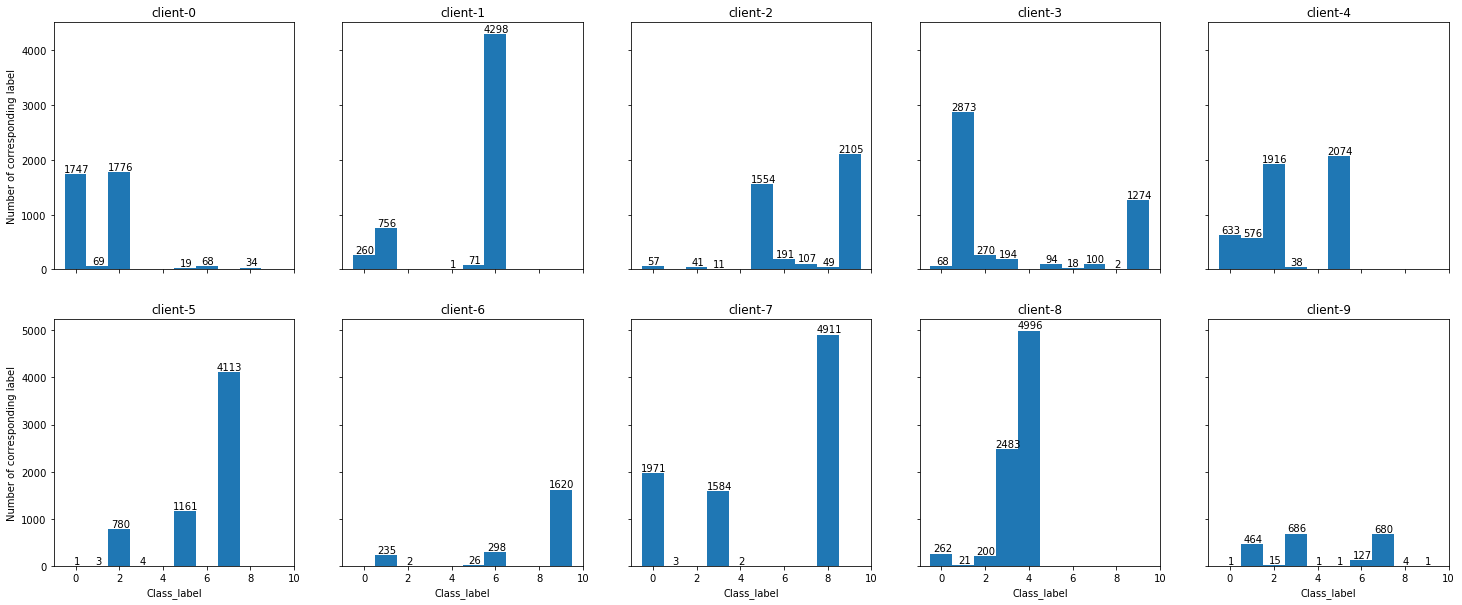

In [39]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 5, sharex='col', sharey='row',figsize=(25,10))
for i in range(10):
    if i==0:
        ax[i//5,i%5].set_ylabel("Number of corresponding label")
    elif i>5:
        ax[i//5,i%5].set_xlabel("Class_label")
    elif i==5:
        ax[i//5,i%5].set_ylabel("Number of corresponding label")
        ax[i//5,i%5].set_xlabel("Class_label")
        
    ax[i//5,i%5].set_xlim(-1,10)
    ax[i//5,i%5].bar(list(x[i].keys()),list(x[i].values()),width = 1)
    ax[i//5,i%5].set_title("client-{0}".format(i))
    for m,n in zip(list(x[i].keys()),list(x[i].values())):
        ax[i//5,i%5].text(m+0.05,n+0.05,'%d' %n, ha='center',va='bottom')
plt.show()

In [40]:
from math import log
# https://github.com/FedEntropy/FedEntropy/blob/main/Algorithm/DynamicEntropy.py
def get_entropy(l):
    entropy = 0.0
    for i in range(len(l)):
        entropy += - l[i] * log(l[i], 2)
    return entropy

entropy = []
for j in range(10):
    sum_=sum(list(x[j].values()))
    p = [i/sum_ for i in list(x[j].values())]
    entropy.append(get_entropy(p))
entropy

[1.3341701870769263,
 0.9531125044779111,
 1.618474022151909,
 1.7161082470734144,
 1.8302514727911654,
 1.2314694360694074,
 1.1427751309347505,
 1.404663111348754,
 1.2643212214786188,
 1.8976525119055716]

In [41]:
dataidx_0 = np.where(np.array(cifar_dataTrain.targets)==0)
idx_0 = dataidx_0[0][:80]
# dataidx_1 = np.where(np.array(cifar_dataTrain.targets)==1)
# idx_1 = dataidx_1[0][:31]
# dataidx_2 = np.where(np.array(cifar_dataTrain.targets)==2)
# idx_2 = dataidx_2[0][:42]
# # dataidx_3 = np.where(np.array(cifar_dataTrain.targets)==3)
# # idx_3 = dataidx_3[3][:]
# # dataidx_4 = np.where(np.array(cifar_dataTrain.targets)==4)
# # idx_4 = dataidx_4[0][:]
# # dataidx_5 = np.where(np.array(cifar_dataTrain.targets)==5)
# # idx_5 = dataidx_5[0][:]
# dataidx_6 = np.where(np.array(cifar_dataTrain.targets)==6)
# idx_6 = dataidx_6[0][:865]
# # dataidx_7 = np.where(np.array(cifar_dataTrain.targets)==7)
# # idx_7 = dataidx_7[0][:]
# # dataidx_8 = np.where(np.array(cifar_dataTrain.targets)==8)
# # idx_8 = dataidx_8[0][:]
# # dataidx_9 = np.where(np.array(cifar_dataTrain.targets)==9)
# # idx_9 = dataidx_9[0][:]

In [42]:
# train_dl_global,test_dl,train_ds_global,test_ds = get_dataloader("cifar10", './', 64, 32, noise_level=0)
# test_ds.data.shape[0]

In [43]:
# train_dl,test_dl,train_ds,test_ds = get_dataloader("cifar10", './', 64, 32, dataidxs=net_dataidx_map[9], noise_level=0)
# test_ds.data.shape[0]

In [44]:
# train_ds.data = np.append(train_ds_.data,train_ds.data,axis=0)
# train_ds.target = np.append(train_ds_.target,train_ds.target,axis=0)
# train_ds

In [45]:
# s=train_ds.data[0].copy()
# size = train_ds.data.shape[0]
# train_ds.data = train_ds.data[:500]
# for j in range(10):
#     if j==1:
#         continue
#     for i in range(int(size/10)):
#         s=train_ds.data[i]
#         train_ds.data = np.append(train_ds.data,s.reshape(1,32,32,3),axis=0)
#         train_ds.target = np.append(train_ds.target,np.array((j,)),axis=0)


In [46]:
# Image.fromarray(train_ds.data[40]).resize((256,256))

In [47]:
# train_dl = data.DataLoader(dataset=train_ds, batch_size=64, drop_last=False, shuffle=True)
# train_dl

In [54]:
conf_matrix=np.array([
    [0,1000,0,0,0,0,0,0,0,0],
    [0,1000,0,0,0,0,0,0,0,0],
    [0,1000,0,0,0,0,0,0,0,0],
    [0,1000,0,0,0,0,0,0,0,0],
    [0,1000,0,0,0,0,0,0,0,0],
    [0,1000,0,0,0,0,0,0,0,0],
    [0,1000,0,0,0,0,0,0,0,0],
    [0,1000,0,0,0,0,0,0,0,0],
    [0,1000,0,0,0,0,0,0,0,0],
    [0,1000,0,0,0,0,0,0,0,0],
    
])

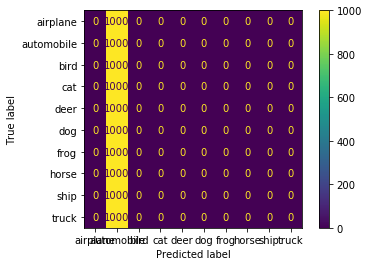

In [55]:
#画出混淆矩阵
#!pip install --upgrade scikit-learn
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# ConfusionMatrixDisplay 需要的参数: confusion_matrix(混淆矩阵), display_labels(标签名称列表)
labels=["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels)
disp.plot()
plt.show()


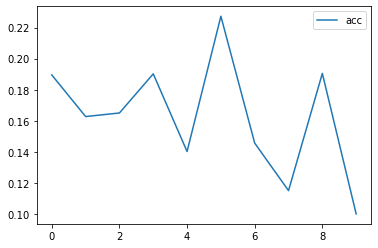

In [57]:
acc = np.array([0.189500, 0.162700, 0.16500, 0.190200, 0.140200, 0.227300,0.145600,0.115000,0.190500,0.100000])
plt.plot(range(10),acc,label="acc")
plt.legend()
plt.show()

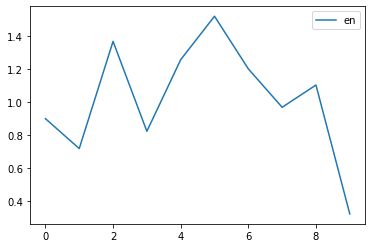

In [56]:
entropy=[0.9000217994846605,
 0.7189019246974966,
 1.3672891064649537,
 0.8233513440074104,
 1.2564880022932812,
 1.5192966908812777,
 1.2009083641903644,
 0.9686101132032778,
 1.1031978667031486,
 0.3236351689336191]
plt.plot(range(10),entropy,label="en")
plt.legend()
plt.show()

In [59]:
# train_dl_global,test_dl,train_ds_global,test_ds = get_dataloader("cifar10", './', 64, 32, noise_level=0)
net_local = {}
for i in range(10):
    net_local[i] = ModelFedCon("simple-cnn",256,10)
    
net_global = ModelFedCon("simple-cnn",256,10)
net_global = net_global.cpu()
train_dl_global,test_dl,train_ds_global,test_ds = get_dataloader("cifar10", './', 64, 32, noise_level=0)

for round in range(10):
    logger.info("in comm round:" + str(round))
    nets_this_round=[]
    global_w = net_global.state_dict()
    
    net_idx = np.where(entropy>np.mean(entropy))[0]
    entropy_weight = [entropy[i] for i in net_idx]
    entropy_weight = [i/sum(entropy_weight) for i in entropy_weight]
    
    for per_net in net_idx:
        nets_this_round.append(net_local[per_net])
        
    # server to client
    for net in nets_this_round:
        net.load_state_dict(global_w)
    
    ##################################### start train ##############################################
    for i in range(10):
        logger.info('Training network %s' % str(i))
        train_dl,test_dl,train_ds,test_ds = get_dataloader("cifar10", './', 64, 32, dataidxs=net_dataidx_map[i], noise_level=0)

        train_dataloader=train_dl
        test_dataloader=test_dl
        epochs=10
        lr=0.01
    #     net_local[i] = ModelFedCon("simple-cnn",256,10)
    #     net = nn.DataParallel(net)
        net_local[i] = net_local[i].cpu()
        # net.cuda()
        device= 'cpu'
        optimizer = optim.SGD(filter(lambda p: p.requires_grad, net_local[i].parameters()), lr=lr, momentum=0.9,
                                      weight_decay=1e-5)
        criterion = nn.CrossEntropyLoss() # .cuda()

        cnt = 0

        for epoch in range(epochs):
            epoch_loss_collector = []
            for batch_idx, (x, target) in enumerate(train_dataloader):
        #         x, target = x.cuda(), target.cuda()

                optimizer.zero_grad()
                x.requires_grad = False
                target.requires_grad = False
                target = target.long()

                _,_,out = net_local[i](x)
                loss = criterion(out, target)

                loss.backward()
                optimizer.step()

                cnt += 1
                epoch_loss_collector.append(loss.item())

            epoch_loss = sum(epoch_loss_collector) / len(epoch_loss_collector)
            logger.info('Epoch: %d Loss: %f' % (epoch, epoch_loss))

            if epoch % 10 == 0:
                train_acc, _ = compute_accuracy(net_local[i], train_dataloader, device=device)
                test_acc, conf_matrix, _ = compute_accuracy(net_local[i], test_dataloader, get_confusion_matrix=True, device=device)

                logger.info('>> Training accuracy: %f' % train_acc)
                logger.info('>> Test accuracy: %f' % test_acc)

        train_acc, _ = compute_accuracy(net_local[i], train_dataloader, device=device)
        test_acc, conf_matrix, _ = compute_accuracy(net_local[i], test_dataloader, get_confusion_matrix=True, device=device)

        logger.info('>> Training accuracy: %f' % train_acc)
        logger.info('>> Test accuracy: %f' % test_acc)
        net_local[i].to('cpu')

        logger.info(' ** Training complete **')
    
    ##################################### end train ##############################################
    # client to server
    for net_id, net in enumerate(nets_this_round):
        net_para = net.state_dict()
        if net_id == 0:
            for key in net_para:
                global_w[key] = net_para[key] * entropy_weight[net_id]
        else:
            for key in net_para:
                global_w[key] += net_para[key] * entropy_weight[net_id]
            
    net_global.load_state_dict(global_w)
    
    logger.info('global n_test: %d' % len(test_dl))
#     global_model.cuda()
    train_acc, train_loss = compute_accuracy(net_global, train_dl_global, device=device)
    test_acc, conf_matrix, _ = compute_accuracy(net_global, test_dl, get_confusion_matrix=True, device=device)

    logger.info('>> Global Model Train accuracy: %f' % train_acc)
    writer.add_scalar("Train_Acc",train_acc,round)
    logger.info('>> Global Model Test accuracy: %f' % test_acc)
    writer.add_scalar("Test_Acc", test_acc, round)
    logger.info('>> Global Model Train loss: %f' % train_loss)
    writer.add_scalar("Train_Loss", train_loss, round)
    
    net_global.to('cpu')
    

Files already downloaded and verified
Files already downloaded and verified


INFO:root:in comm round:0
INFO:root:Training network 0


Files already downloaded and verified


KeyboardInterrupt: 

In [26]:
list(net_idx)

[3, 5, 7, 9]

In [129]:
a=np.concatenate(train_ds_global.data[:30], axis=1)

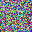

In [33]:
# %matplotlib inline
image = np.concatenate([im[0], im[1]], axis=1)
Image.fromarray(image)

In [36]:
train_ds.data[0].shape

(32, 32, 3)


# Data

In [11]:
import torchvision.transforms as transforms
from torchvision.datasets import MNIST, EMNIST, CIFAR10,CIFAR100
from PIL import Image

In [12]:
transform = transforms.Compose([transforms.ToTensor()])

In [23]:
cifar_dataTrain = CIFAR10("./", True, transform, None, True)
cifar_dataTest = CIFAR10("./", False, transform, None, True)


Files already downloaded and verified


In [14]:
import torchvision
torchvision.__version__

'0.4.0+cu92'

In [25]:
cifar_dataTrain.data[111].shape

(32, 32, 3)

In [52]:
#cifar_dataTrain.data

In [44]:
dataidx_1 = np.where(np.array(cifar_dataTrain.targets)==1)
# dataidx_1[0][0]
data_1 = [cifar_dataTrain[dataidx_1[0][i]] for i in range(len(dataidx_1[0]))]
data_1

4

In [51]:
len(data_1)

5000

In [17]:
label_idx={}
for i in range(10):
    label_idx[i]=np.where(np.array(cifar_dataobj.targets)==i)[0]
label_idx

NameError: name 'np' is not defined

In [37]:
new_data={}
for i in range(10):
    new_data[i] = 0
    for j in label_idx[0]:
        new_data[i]+=cifar_dataobj.data[j]
    np.divide(new_data[i],1000)
new_data[0].shape


(32, 32, 3)

In [40]:
for _ in range(10):
    im = Image.fromarray(new_data[_]).resize((256,256), Image.ANTIALIAS)
    im.show()

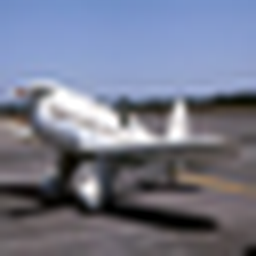

In [32]:
im = Image.fromarray(cifar_dataobj.data[a[-1]]).resize((256,256), Image.ANTIALIAS)
im

In [8]:
import numpy as np
np.unique(cifar_dataobj.targets,return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000],
       dtype=int64))

In [24]:
y_train = np.array(cifar_dataobj.targets)
y_train

array([3, 8, 8, ..., 5, 1, 7])

In [275]:
min_size = 0
min_require_size = 10
K = 10
beta=0.01
n_parties=10
N = y_train.shape[0]
net_dataidx_map = {}

In [276]:
while min_size < min_require_size:
    
    idx_batch = [[] for _ in range(n_parties)]
    for k in range(K):
        # select those labels corresponding to the k.
        idx_k = np.where(y_train == k)[0]
        np.random.shuffle(idx_k)
        
        proportions = np.random.dirichlet(np.repeat(beta, n_parties))
        proportions = np.array([p * (len(idx_j) < N / n_parties) for p, idx_j in zip(proportions, idx_batch)])
        proportions = proportions / proportions.sum()
        proportions = (np.cumsum(proportions) * len(idx_k)).astype(int)[:-1]
        idx_batch = [idx_j + idx.tolist() for idx_j, idx in zip(idx_batch, np.split(idx_k, proportions))]
        min_size = min([len(idx_j) for idx_j in idx_batch])

for j in range(n_parties):
    np.random.shuffle(idx_batch[j])
    net_dataidx_map[j] = idx_batch[j]
# net_dataidx_map

In [277]:
def record_net_data_stats(y_train, net_dataidx_map):
    net_cls_counts = {}

    for net_i, dataidx in net_dataidx_map.items():
        unq, unq_cnt = np.unique(y_train[dataidx], return_counts=True)
        tmp = {unq[i]: unq_cnt[i] for i in range(len(unq))}
        net_cls_counts[net_i] = tmp

    data_list=[]
    for net_id, data in net_cls_counts.items():
        n_total=0
        for class_id, n_data in data.items():
            n_total += n_data
        # just data valumes, not related to categories.
        data_list.append(n_total)
    print('mean:', np.mean(data_list))
    print('std:', np.std(data_list))
#     logger.info('Data statistics: %s' % str(net_cls_counts))

    return net_cls_counts

In [278]:
record=record_net_data_stats(y_train,net_dataidx_map)

mean: 1000.0
std: 542.9703490983646


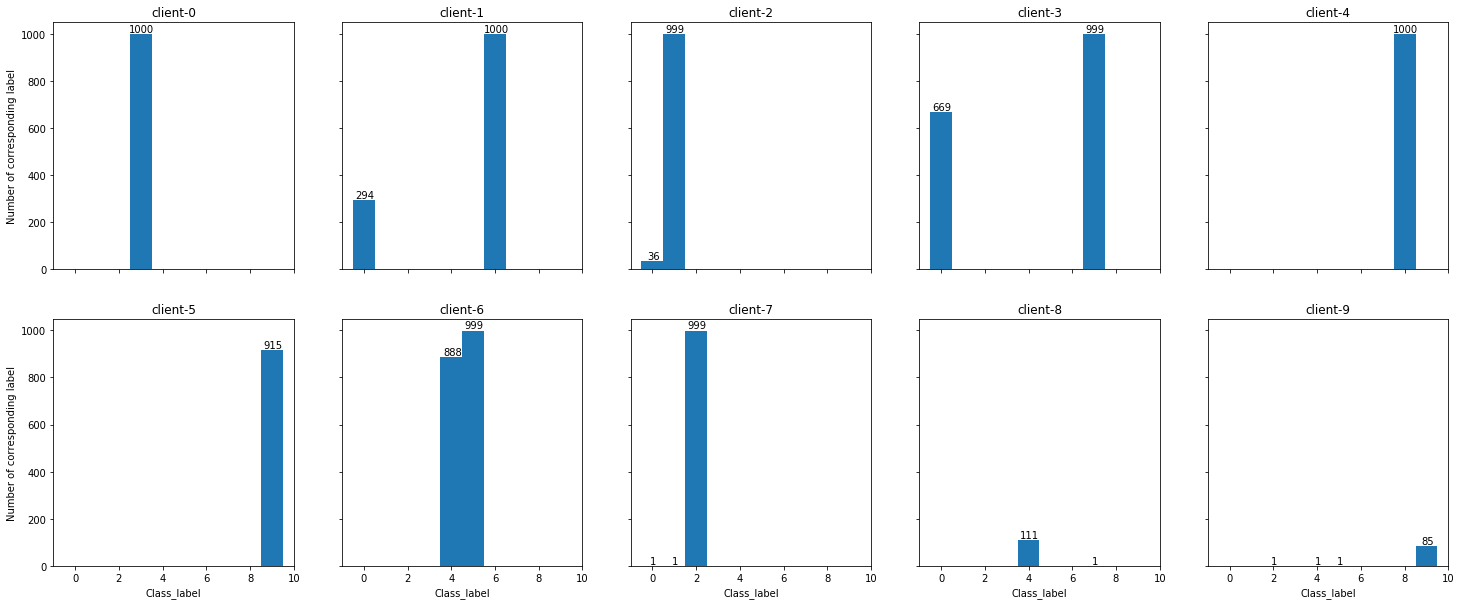

In [279]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 5, sharex='col', sharey='row',figsize=(25,10))
for i in range(n_parties):
    if i==0:
        ax[i//5,i%5].set_ylabel("Number of corresponding label")
    elif i>5:
        ax[i//5,i%5].set_xlabel("Class_label")
    elif i==5:
        ax[i//5,i%5].set_ylabel("Number of corresponding label")
        ax[i//5,i%5].set_xlabel("Class_label")
        
    ax[i//5,i%5].set_xlim(-1,10)
    ax[i//5,i%5].bar(list(record[i].keys()),list(record[i].values()),width = 1)
    ax[i//5,i%5].set_title("client-{0}".format(i))
    for m,n in zip(list(record[i].keys()),list(record[i].values())):
        ax[i//5,i%5].text(m+0.05,n+0.05,'%d' %n, ha='center',va='bottom')

plt.savefig("./beta-{0}-partition.png".format(beta),dpi=300,bbox_inches='tight')
plt.show()

In [199]:
# import collections

# new_record={}
# for i in range(10):
#     for j in range(10):
#         if j not in record[i].keys():
#             record[i][j]=0
#     new_record[i]=collections.OrderedDict(sorted(record[i].items()))
# new_record

# Visualization

Computing t-SNE embedding


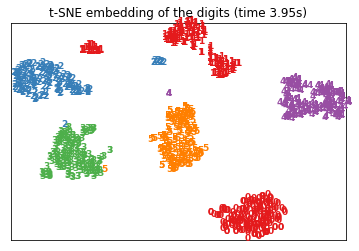

In [41]:
# coding='utf-8'
"""t-SNE对手写数字进行可视化"""
from time import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.manifold import TSNE


def get_data():
    digits = datasets.load_digits(n_class=6)
    data = digits.data
    label = digits.target
    n_samples, n_features = data.shape
    return data, label, n_samples, n_features


def plot_embedding(data, label, title):
    x_min, x_max = np.min(data, 0), np.max(data, 0)
    data = (data - x_min) / (x_max - x_min)

    fig = plt.figure()
    ax = plt.subplot(111)
    for i in range(data.shape[0]):
        plt.text(data[i, 0], data[i, 1], str(label[i]),
                 color=plt.cm.Set1(label[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})
    plt.xticks([])
    plt.yticks([])
    plt.title(title)
    return fig


def main():
    data, label, n_samples, n_features = get_data()
    print('Computing t-SNE embedding')
    tsne = TSNE(n_components=2, init='pca', random_state=0)
    t0 = time()
    result = tsne.fit_transform(data)
    fig = plot_embedding(result, label,
                         't-SNE embedding of the digits (time %.2fs)'
                         % (time() - t0))
    plt.show(fig)


if __name__ == '__main__':
    main()